# Peptide Detectability Prediction 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/).

One of the example datasets used in this notebook is deposited in the ProteomeXchange Consortium via the MAssIVE partner repository with the identifier PXD024364. The other dataset is deposited to the ProteomeXchange Consortium via the PRIDE partner repository with identifier PXD010154. 

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

In [1]:
# # install the DLOmix package in the current environment using pip

# !python -m pip install -q git+https://github.com/wilhelm-lab/dlomix

The available modules in the framework are as follows:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import dlomix
import sys
import os

In [3]:
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/data')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/models')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/reports')
# sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/pretrained_models')


In [4]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix, plot_roc_curve, roc_curve, auc, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
# import seaborn as sns
# import time
# import sys
# import os

- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around TensorFlow Dataset
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations (e.g. Detectability Prediction)
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)
- `utils`: helper modules

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

## Model

We can now create the model. The model architecture is an encoder-decoder with an attention mechanism, that is based on Bidirectional Recurrent Neural Network (BRNN) with Gated Recurrent Units (GRU). Both the Encoder and Decoder consists of a single layer, with the Decoder also including a Dense layer. The model has the default working arguments.

**Note**: It is important to ensure that the padding length used in the dataset object matches the sequence length passed to the model.

In [5]:
from dlomix.models import detetability_model
from dlomix.detectability_model_constants import CLASSES_LABELS, alphabet

In [6]:
total_num_classes = len(CLASSES_LABELS)
input_dimension = len(alphabet)
num_cells = 64

model = detetability_model.detetability_model(num_units = num_cells,
                                              num_clases = total_num_classes)

model.compile(optimizer = 'adam',
              loss = 'CategoricalCrossentropy',
              metrics = 'categorical_accuracy')

### Model Weights Configuration

In the following section, you need to specify the path to the model weights you wish to use. The default path provided is set to the weights for the **Pfly** model, which is the fine-tuned model mentioned in the publication associated with this notebook.

- **Using the Default Pfly Model**: If you are utilizing the fine-tuned Pfly model as described in the publication, you can keep the default path unchanged. This will load the model weights for Pfly, as specified in the original research.

- **Using the Base Model or Different Weights**: If you intend to use the base model or have different weights (e.g., for a custom model), you should update the path to reflect the location of these weights. Replace the default path with the path to the weights file for the base model or any other model you are using.

In [7]:
## Loading model's weights 

model.load_weights('pretrained_models\original_detectability_fine_tuned_model\original_detectability_fine_tuned_model')

## Workflow Overview

This notebook supports two different workflows depending on your dataset:<br>

- **Labeled Data**: Use this pipeline when your dataset includes ground truth labels. In this case, the model not only makes predictions but also generates a detailed evaluation report, thanks to the comparison between the true labels and the predicted values. 



- **Unlabeled Data**: Use this pipeline when your dataset does not include labels. Here, the focus is on making predictions only, without generating a detailed performance report, as there are no labels to compare against.

### Notebook Structure

Subtitles throughout the notebook indicate the sections for each type of data:

- **Labeled Data Sections**: Follow these when your dataset includes labels to receive predictions and a comprehensive evaluation report.

- **Unlabeled Data Sections**: Use these when your dataset lacks labels, focusing solely on generating predictions.

Make sure to select the appropriate pipeline based on your dataset to ensure proper usage and interpretation of the results.

# Labeled Data

## 1. Load Data 

We can import the dataset class and create an object of type `detectability_dataset`. This object wraps around TensorFlow dataset objects for training, validation, and testing or for only testing. This can be specified by the arguments `val_ratio`, `test_ratio` and `test`.

**Note**: If the classes are provided the following encoding should be used: Non-Flyer: 0, Weak Flyer: 1, Intermediate Flyer: 2, Strong Flyer: 3.

In [8]:
from dlomix.data.detectability_dataset import detectability_dataset

In [9]:
Sinitcyn_test_data = './example_dataset/Sinitcyn_test_data.csv'
Wang_test_data = './example_dataset/Wang_data.csv'

max_pep_length = 40
BATCH_SIZE = 128
            
detectability_data = detectability_dataset(data_source = Sinitcyn_test_data, 
                                           seq_length = max_pep_length,
                                           split_on_protein = False, 
                                           batch_size = BATCH_SIZE, 
                                           val_ratio = 0.1, 
                                           test_ratio = 0.2, 
                                           test = True)

The detectability dataset can be directly used with both standard or custom `Keras` models. This dataset wrapper includes predefined splits for training, validation, and testing. The corresponding data subsets can be accessed through the attributes `.train_data`, `.val_data` and `.test_data`. The length of each subset is expressed in terms of batches, where the total number of examples is calculated as `total examples = batch_size x len`. In case the parameter `test = True` is set, only the test dataset is generated.

In [10]:
"Test examples", BATCH_SIZE * len(detectability_data.test_data)

('Test examples', 60288)

It is also possible to obtain the different dataset as DataFrames calling the attribute `.get_split_dataframe` and specifying the specific set `train`, `val` and `test`.

In [11]:
test_data_df = detectability_data.get_split_dataframe(split = "test")
test_data_df.head(5)

,Sequences,Classes,Proteins
0,ASSFHEFAR,1,Q9NU19
1,EVEHMTR,0,Q96CN5
2,SSFQCENPEVGLGEK,1,O15062
3,EMNTEAEK,1,Q5TKA1
4,VSCAGQMLEVQPGLYFGGAAAVAEPDHLR,3,Q9UNI6


## 2. Testing and Reporting

We use the test dataset to assess our model's performance, which is only applicable if labels are available. The `detectability_report` class allows us to compute various metrics, generate reports, and create plots for a comprehensive evaluation of the model.

Note: The reporting module is currently under development, so some features may be unstable or subject to change.

In [12]:
# use model.predict from keras directly on the testdata

predictions = model.predict(detectability_data.test_data)

471/471 [==============================] - 8s 7ms/step


In [13]:
# To calculate evaluation metrics against predictions, we need to obtain the targets and dataframes for a specific dataset split. 
# The `get_split_targets` and `get_split_dataframe` functions from the `detectability_dataset` class facilitate this process.

test_targets = detectability_data.get_split_targets(split = "test")
test_data_df = detectability_data.get_split_dataframe(split = "test")

In [14]:
from dlomix.reports.detectability_report import detectability_report, predictions_report
WANDB_REPORT_API_DISABLE_MESSAGE=True

wandb: WARNING The v1 API is deprecated and will be removed in a future release.  Please move to v2 by setting the env var WANDB_REPORT_API_ENABLE_V2=True.  This will be on by default in a future release.
wandb: WARNING You can disable this message by setting the env var WANDB_REPORT_API_DISABLE_MESSAGE=True


#### Generate a report using the `detectability_report` function by providing the following parameters:

- **targets**: The true labels for the dataset, used to evaluate the model's performance.
- **predictions**: The model's output predictions for the dataset, which will be compared against the targets.
- **input_data_df**: The DataFrame containing the input data used for generating predictions.
- **output_path**: The path where the generated report will be saved.
- **history**: The training history object (e.g., containing metrics from training) if available. Set this to `None` if not applicable, such as when the report is generated for predictions without training.
- **rank_by_prot**: A parameter indicating whether to rank peptides by their associated proteins. 
- **threshold**: The threshold value used for classification. This parameter helps in determining the decision boundary for classification tasks. The default is `None`, which means no specific threshold is applied.
- **name_of_dataset**: The name of the dataset used for generating the predictions. This information will be included in the report to provide context about the specific data set on which the predictions were made.
- **name_of_model**: The name of the model used to generate the predictions. This will be noted in the report to specify which model was employed and provide context regarding the predictions.

In [15]:
report = detectability_report(targets = test_targets, 
                              predictions = predictions, 
                              input_data_df = test_data_df, 
                              output_path = "./output/report_on_Sinitcyn_2000_proteins_test_set_labeled", 
                              history = None, 
                              rank_by_prot = False,
                              threshold = None,
                              name_of_dataset = 'Sinitcyn 2000 proteins test set',
                              name_of_model = 'Fine-tuned model (Original)')

C:\Users\JZ05DL\OneDrive - Aalborg Universitet\Desktop\Naim code for dlomix\dlomix\dlomix\reports\Report_Naim.py:30: UserWarning: The passed History object is None, no training/validation data can be reported.
  warnings.warn(


Binary Accuracy: 0.79

Categorical Accuracy: 0.45

Matthews Correlation Coefficient (MCC): 0.51

True Positive Rate (Recall): 0.86

False Positive Rate (Specificity): 0.63

Precision: 0.83

F1 Score: 0.85


In [16]:
results_df = report.detectability_report_table
results_df

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions,Rank
0,GASHHVYADQPHIFNAVVEEICDSVD,Q8TB40,0.206,0.287,0.496,0.011,0.989,Intermediate Flyer,Strong Flyer,Flyer,Flyer,1
1,ELPLGPADAMELADHLVK,Q8N201,0.104,0.225,0.657,0.014,0.986,Strong Flyer,Strong Flyer,Flyer,Flyer,2
2,EVLFQHSGFQQS,Q96CD2,0.179,0.310,0.495,0.016,0.984,Intermediate Flyer,Strong Flyer,Flyer,Flyer,3
3,LLGAFHNPK,P50213,0.127,0.230,0.627,0.016,0.984,Intermediate Flyer,Strong Flyer,Flyer,Flyer,4
4,SGEHLNPDQLEAVEK,Q6IMN6,0.125,0.234,0.625,0.017,0.984,Intermediate Flyer,Strong Flyer,Flyer,Flyer,5
...,...,...,...,...,...,...,...,...,...,...,...,...
60180,AASGVFWWLGIGWYQFVTLISWLNVFLLTR,O94901,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,60181
60181,MHLFTALQLLCLALLWAVMSTAASLAFPFILILTVPLR,P04920,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,60182
60182,SLQVLLLLLLLLLLLPGMWAEAGLPR,Q9UIW2,0.000,0.000,0.000,0.999,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,60183
60183,CLLALVLFCAWGTLAVVAQKPGAGCPSR,Q92626,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer,60184


In [17]:
# directory = './output/reports/report_on_Sinitcyn_prediction_labeled'

# if not os.path.exists(directory):
#     os.makedirs(directory)

# path_ = directory + "/predictions_borrar.csv"
    
# results_df.to_csv(path_, index=False)

The detectability_report function allows you to generate various plots to visualize and evaluate model performance. This function provides a comprehensive set of visualizations to help in understanding the results of our model predictions. Here’s how you can use it:

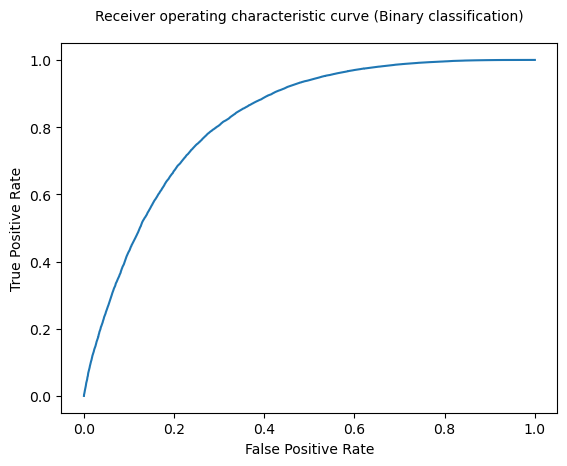

In [18]:
report.plot_roc_curve_binary()

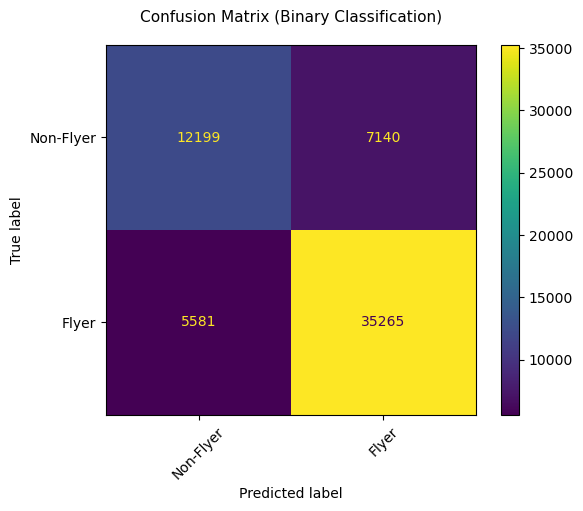

In [19]:
report.plot_confusion_matrix_binary()

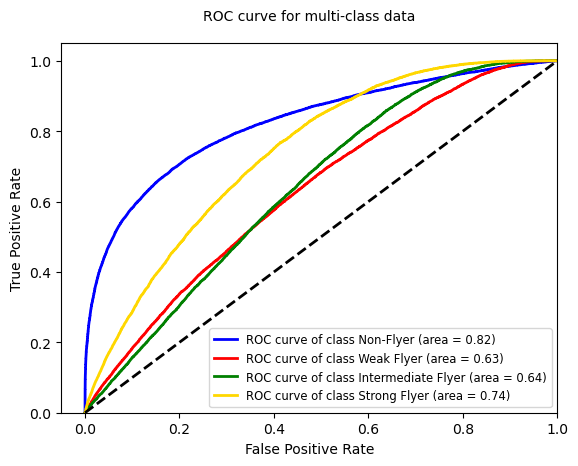

In [20]:
report.plot_roc_curve()

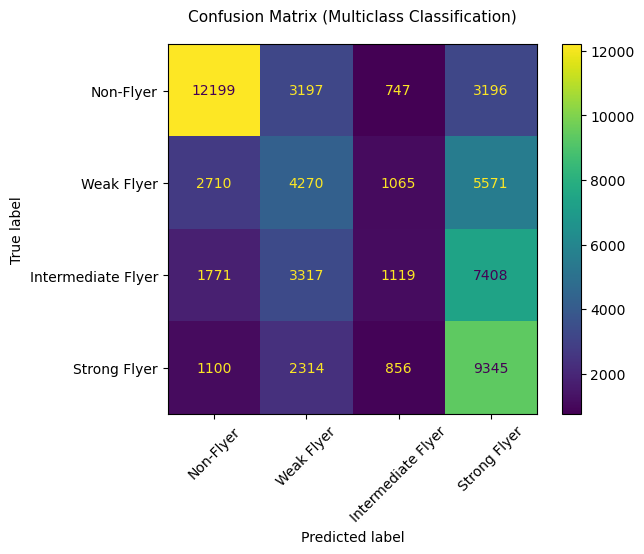

In [21]:
report.plot_confusion_matrix_multiclass()

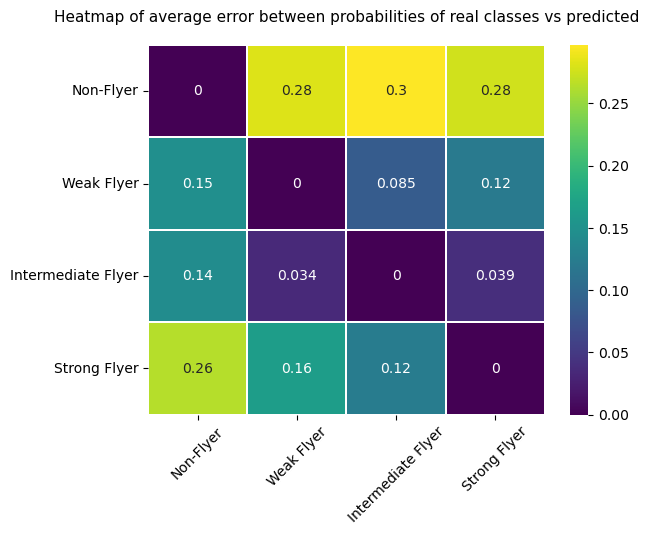

In [22]:
report.plot_heatmap_prediction_prob_error()

We can also produce a complete report with all the relevant plots in one PDF file by calling the `generate_report` function.

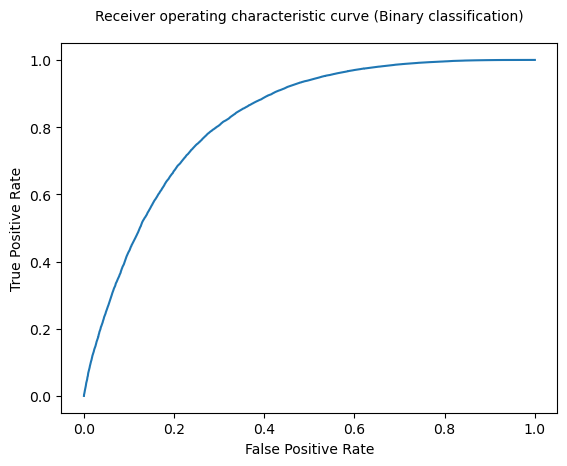

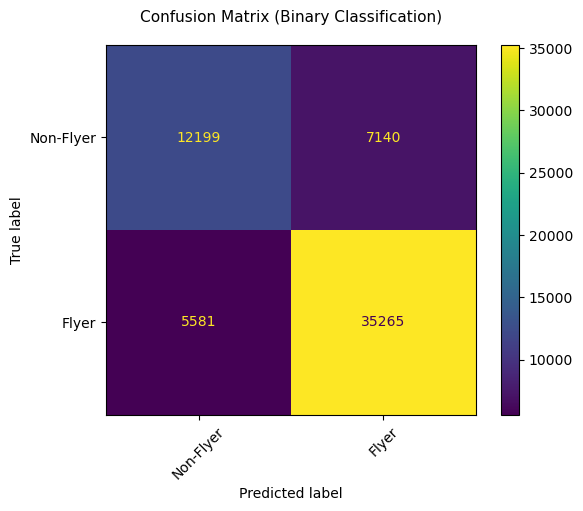

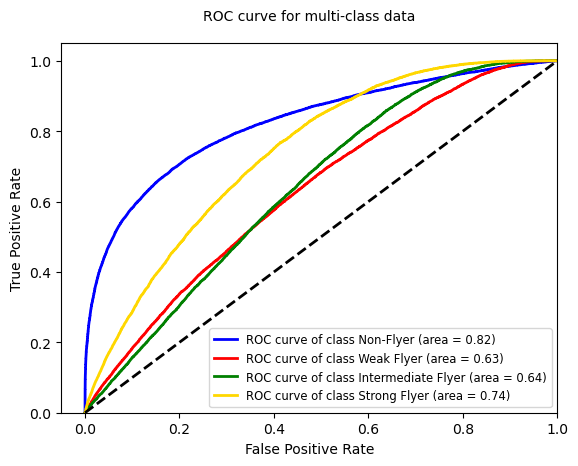

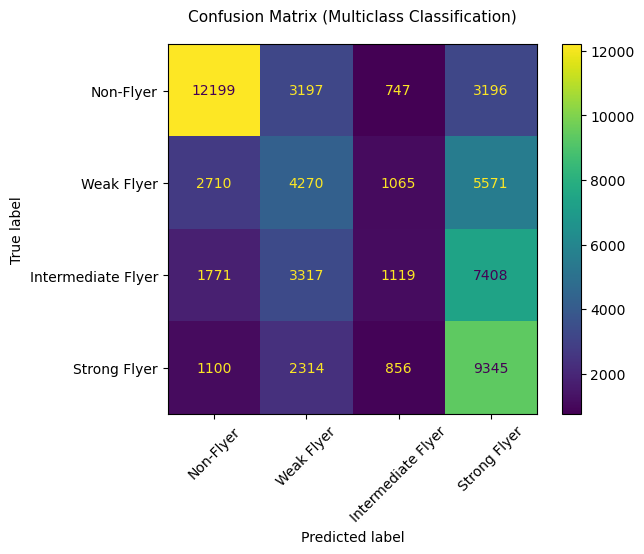

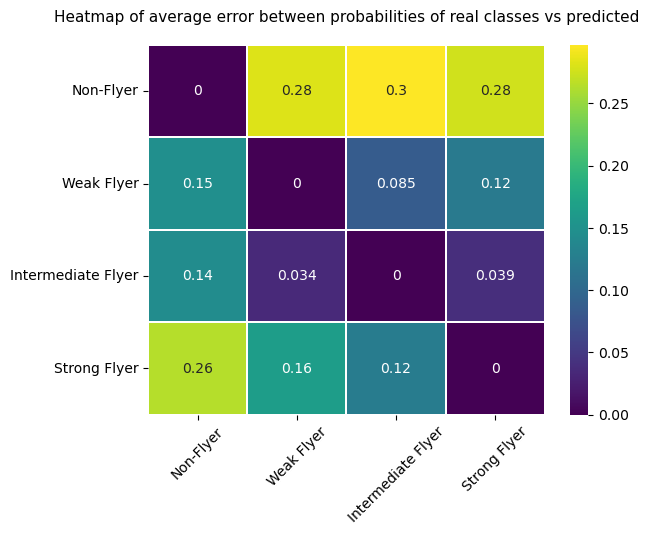

In [23]:
report.generate_report()

# Unlabeled Data

## 1. Load data

For predicting on unlabeled data, follow the same workflow as previously described. Specifically, create an object of type  `detectability_dataset` using the data intended for prediction. This object will manage the unlabeled data and facilitate the generation of predictions.

This workflow is intended for scenarios where the data does not have labels, focusing solely on making predictions without the need for labeled training or validation sets.

In [24]:
Sinitcyn_test_unlabeled_data = './example_dataset/Sinitcyn_test_data_unlabeled.csv'

BATCH_SIZE = 128
            
unlabeled_test_data = detectability_dataset(data_source = Sinitcyn_test_unlabeled_data, 
                                            protein_data = "proteins",
                                            split_on_protein = False, 
                                            seq_length = 40, 
                                            batch_size = BATCH_SIZE, 
                                            val_ratio = 0, 
                                            test_ratio = 0, 
                                            test = True)

In [25]:
"Test examples", BATCH_SIZE * len(unlabeled_test_data.test_data)

('Test examples', 60288)

In [26]:
test_data_FT = unlabeled_test_data.get_split_dataframe(split = "test")
test_data_FT.head(5)

,Sequences,Proteins
0,ASSFHEFAR,Q9NU19
1,EVEHMTR,Q96CN5
2,SSFQCENPEVGLGEK,O15062
3,EMNTEAEK,Q5TKA1
4,VSCAGQMLEVQPGLYFGGAAAVAEPDHLR,Q9UNI6


## 2. Predicting and reporting

We use the previously loaded model to generate predictions on the dataset. If labels are not available, you can utilize the `predictions_report` function to produce a clear and organized report based on these predictions. This function takes the model’s predictions and generates a comprehensive summary, which helps in evaluating and interpreting the results effectively. Note that the `predictions_report` function is specifically designed for scenarios where labels are not present.

In [27]:
# use model.predict from keras directly on the testdata

predictions = model.predict(unlabeled_test_data.test_data)

471/471 [==============================] - 6s 7ms/step


In [28]:
# To generate the predictions_report, we need to obtain the dataframes for a specific dataset split. 
# The get_split_dataframe` function from the `detectability_dataset` class facilitate this process.

test_data_df = unlabeled_test_data.get_split_dataframe(split = "test")

In [29]:
test_data_df

,Sequences,Proteins
0,ASSFHEFAR,Q9NU19
1,EVEHMTR,Q96CN5
2,SSFQCENPEVGLGEK,O15062
3,EMNTEAEK,Q5TKA1
4,VSCAGQMLEVQPGLYFGGAAAVAEPDHLR,Q9UNI6
...,...,...
60180,SGLLNMTK,Q9BRR9
60181,HSNHLALIFK,Q13233
60182,LCEQLSTVIPNSHVYYR,Q9H9Y2
60183,FHSPQHPPEEFGFGFSFSPGGGIR,O00165


#### Generate a report using the `predictions_report` function by providing the following parameters:

- **predictions**: The model's output predictions for the dataset, which will be compared against the targets.
- **input_data_df**: The DataFrame containing the input data used for generating predictions.
- **output_path**: The path where the generated report will be saved.
- **rank_by_prot**: A parameter indicating whether to rank peptides by their associated proteins. 
- **threshold**: The threshold value used for classification. This parameter helps in determining the decision boundary for classification tasks. The default is `None`, which means no specific threshold is applied.

In [30]:
new_predictions_report = predictions_report(predictions = predictions, 
                                            input_data_df = test_data_df, 
                                            output_path = "./output/report_on_Sinitcyn_2000_proteins_test_set_unlabeled", 
                                            rank_by_prot = False,
                                            threshold = None)

In [31]:
results_unlabeled_df = new_predictions_report.predictions_report
results_unlabeled_df

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Predictions,Binary Predictions,Rank
0,GASHHVYADQPHIFNAVVEEICDSVD,Q8TB40,0.206,0.287,0.496,0.011,0.989,Strong Flyer,Flyer,1
1,ELPLGPADAMELADHLVK,Q8N201,0.104,0.225,0.657,0.014,0.986,Strong Flyer,Flyer,2
2,LLGAFHNPK,P50213,0.127,0.230,0.627,0.016,0.984,Strong Flyer,Flyer,3
3,SGEHLNPDQLEAVEK,Q6IMN6,0.125,0.234,0.625,0.017,0.984,Strong Flyer,Flyer,4
4,EVLFQHSGFQQS,Q96CD2,0.179,0.310,0.495,0.016,0.984,Strong Flyer,Flyer,5
...,...,...,...,...,...,...,...,...,...,...
60180,AASGVFWWLGIGWYQFVTLISWLNVFLLTR,O94901,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,60181
60181,MHLFTALQLLCLALLWAVMSTAASLAFPFILILTVPLR,P04920,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,60182
60182,SLQVLLLLLLLLLLLPGMWAEAGLPR,Q9UIW2,0.000,0.000,0.000,0.999,0.000,Non-Flyer,Non-Flyer,60183
60183,CLLALVLFCAWGTLAVVAQKPGAGCPSR,Q92626,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,60184


In [32]:
# directory = './output/reports/report_on_Sinitcyn_prediction_unlabeled'

# if not os.path.exists(directory):
#     os.makedirs(directory)

# path_ = directory + "/predictions_borrar.csv"
    
# results_unlabeled_df.to_csv(path_, index=False)